In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
import cv2

# load labelled data 
def load_labelled_dataset(path):
    data = load_files(path)
    classified_files = np.array(data['filenames'])
    return classified_files

#load unlabelled data
def load_unlabelled_dataset(path):
    images = []
    for dirpath, subdirs, files in os.walk(path):
        for name in files: 
            if name.endswith(".jpg"):
                images.append(os.path.join(dirpath, name))
    return images

# load datasets. labelled files will be used 
labelled_files = load_labelled_dataset('imgs/train')
unlabelled_files = load_unlabelled_dataset('imgs/test')

# load list of class names
categories = [item[20:-1] for item in sorted(glob("imgs/train/*/"))]

# print statistics about the dataset
print('There are %d total categories.' % len(categories))
print('There are %s total  images.\n' % len(np.hstack([labelled_files, unlabelled_files])))
print('There are %d labelled images.' % len(labelled_files))
print('There are %d unlabelled images.'% len(unlabelled_files))

Using TensorFlow backend.


There are 10 total categories.
There are 102150 total  images.

There are 22424 labelled images.
There are 79726 unlabelled images.


In [2]:
import pandas as pd

#read image names and labels from csv file
def get_driver_data():
    df = pd.read_csv('driver_imgs_list.csv')    
    return df

import numpy as np

#match labels to images reading relevant information from csv file and math them
def match_labels_images(img_paths):
    df = get_driver_data()
    images = []
    labels = []
    for img_path in img_paths:
        image = img_path.split("/")
        im_name = image[-1]
        label = df['classname'][df['img']==im_name]
        str_label = str(label)
        images.append(img_path)
        labels.append(str_label)
    np_images = np.array(images)
    np_labels = np.array(labels)
    
    return np_images, np_labels

X_labelled, y_labelled = match_labels_images(labelled_files)

print(X_labelled.shape[0], 'labelled samples')

22424 labelled samples


In [3]:
from sklearn.model_selection import train_test_split

# split labelled data into train,validation and test sets
X_trainVal, X_test, y_trainVal, y_test = train_test_split(X_labelled, y_labelled, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_trainVal, y_trainVal, test_size=0.2)

# print number of training and test images
print(X_train.shape[0], 'train samples')
print(X_validation.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')


14351 train samples
3588 validation samples
4485 test samples


In [4]:
# define text labels to each classes to show on the plotting section
safe_driving_labels = ['safe driving', 'texting - right', 'talking on the phone - right', 
                       'texting - left', 'talking on the phone - left', 'operating the radio', 
                       'drinking', 'reaching behind', 'hair and make-up', 'talking to passenger']

In [5]:
# retrieve class names from label values into numerical values 0,1,2,3,4,5,7,8 and 9 
# those values are helpful in numerical form when we transfer them into categorical files using np_utils.to_categorical function
def split_target(y_labels):
    y_val =[]

    for y in y_labels:
        y = y.split("c")
        y = y[1].split("\n")
        y_val.append(y[0])
    return y_val

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
from keras.utils import np_utils

#reshape labelled data to match an input form to be used in classifier
def reshape_labelled(X , y):
      
    data = np.array(paths_to_tensor(X), dtype=np.uint8)
    target = np.array(split_target(y), dtype=np.uint8)
    target = np_utils.to_categorical(target, 10)

    #Rescaling images by dividing every pixel in every image by 255
    data = data.astype('float32') / 255
    
    return data, target

# reshape unlabelled data to match input form to use when predicting.
def reshape_unlabelled(X):
    
    data = np.array(paths_to_tensor(X), dtype=np.uint8)  

    #Rescaling images by dividing every pixel in every image by 255
    data = data.astype('float32') / 255
    
    return data

# reshape train, validation and test datasets
X_train, y_train = reshape_labelled(X_train , y_train)
X_validation, y_validation = reshape_labelled(X_validation , y_validation)
X_test, y_test = reshape_labelled(X_test , y_test)

#we select some sample of unlabelled data to plot and see how our model does on unlabelled data
X_unlabelled = reshape_unlabelled(unlabelled_files[:100])

# print shape of training, validation and test.
print('X_train shape:', X_train.shape)
print('X_validation shape:', X_validation.shape)
print('X_test shape:', X_test.shape)

# print number of training and test images
print(X_train.shape[0], 'train samples')
print(X_validation.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

# print shape of unlabelled set
print('X_unlabelled shape:', X_unlabelled.shape)

# print number of unlabelled images
print(X_unlabelled.shape[0], 'unlabelled samples')

100%|██████████| 100/100 [00:00<00:00, 205.09it/s]


X_train shape: (14351, 224, 224, 3)
X_validation shape: (3588, 224, 224, 3)
X_test shape: (4485, 224, 224, 3)
14351 train samples
3588 validation samples
4485 test samples
X_unlabelled shape: (100, 224, 224, 3)
100 unlabelled samples


In [8]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

#Augment the training data
datagen.fit(X_train)

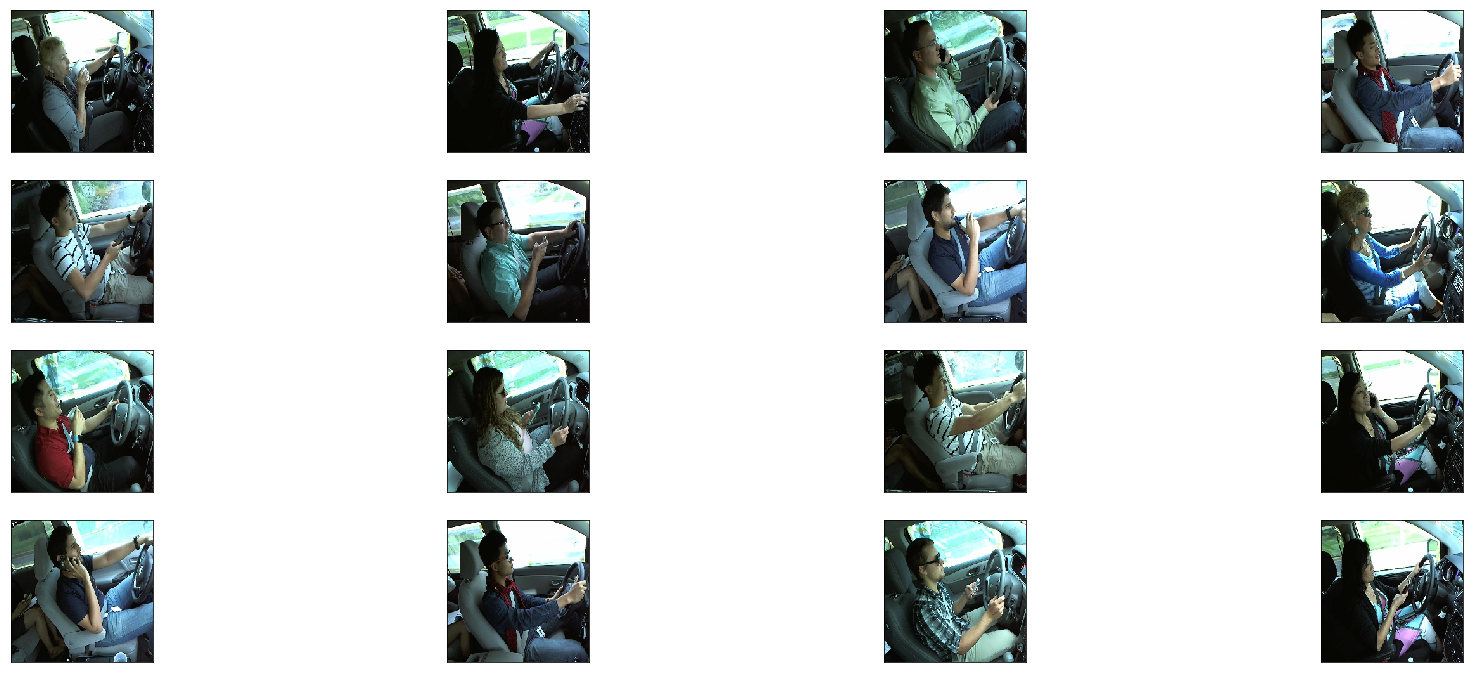

In [9]:
# plot a random sample of augmented training images
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(30, 12))
for i, idx in enumerate(np.random.choice(X_train.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[idx]))    

In [10]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Flatten, Dense
from keras.models import Model

#import ResNet50 model
# input_shape isn't specified and left default to use (224, 224, 3) shape 
#Get back the convolutional part of a VGG network trained on ImageNet
model = ResNet50(weights='imagenet', include_top=False)
model.summary()


#Define input format to calculate define output shape variable
input = Input(shape=(224,224,3),name = 'image_input')

#Use the generated model 
output_shape = model(input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_shape)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

#Create final model 
new_model = Model(input=input, output=x)

#In the summary, weights and layers from ResNet50 part will be hidden, but they will be fit during the training
new_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, None, None, 3) 0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256         conv1[0][0]                      
___________________________________________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              8392704   
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 10)                40970     
Total params: 48,802,698
Trainable params: 48,749,578
Non-trainable params: 53,120
___________________________________________________________

/home/aind2/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


In [11]:
#Compile the model
new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from keras.callbacks import ModelCheckpoint 
# Create a checkpointer to save model weights
checkpointer = ModelCheckpoint(filepath='model.weights.best.ResNet50.hdf5', verbose=1, save_best_only=True)

In [13]:
batch_size = 32
epocs =10
# fit the model using augmented data
hist = new_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch= X_train.shape[0]//batch_size,
                           epochs=epocs, callbacks=[checkpointer], verbose=2,validation_data=(X_validation, y_validation))



Epoch 1/10
Epoch 00000: val_loss improved from inf to 14.32570, saving model to model.weights.best.ResNet50.hdf5
527s - loss: 14.4480 - acc: 0.1020 - val_loss: 14.3257 - val_acc: 0.1112
Epoch 2/10
Epoch 00001: val_loss did not improve
520s - loss: 14.4729 - acc: 0.1021 - val_loss: 14.3257 - val_acc: 0.1112
Epoch 3/10
Epoch 00002: val_loss did not improve
525s - loss: 14.4675 - acc: 0.1024 - val_loss: 14.3257 - val_acc: 0.1112
Epoch 4/10
Epoch 00003: val_loss did not improve
524s - loss: 14.4755 - acc: 0.1019 - val_loss: 14.3257 - val_acc: 0.1112
Epoch 5/10
Epoch 00004: val_loss did not improve
520s - loss: 14.4651 - acc: 0.1026 - val_loss: 14.3257 - val_acc: 0.1112
Epoch 6/10
Epoch 00005: val_loss did not improve
520s - loss: 14.4832 - acc: 0.1014 - val_loss: 14.3257 - val_acc: 0.1112
Epoch 7/10
Epoch 00006: val_loss did not improve
520s - loss: 14.4705 - acc: 0.1022 - val_loss: 14.3257 - val_acc: 0.1112
Epoch 8/10
Epoch 00007: val_loss did not improve
520s - loss: 14.4662 - acc: 0.102

In [15]:
# load the weights that yielded the best validation accuracy
new_model.load_weights('model.weights.best.ResNet50.hdf5')

In [16]:
# evaluate and print test accuracy
score = new_model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.102564102564


In [17]:
# get predictions on the test set
y_hat = new_model.predict(X_test)

In [18]:
from sklearn.metrics import log_loss
#Calculate logloss
log_loss = log_loss(y_test, y_hat)
print('\n', 'Log loss:', log_loss)


 Log loss: 30.9963065421


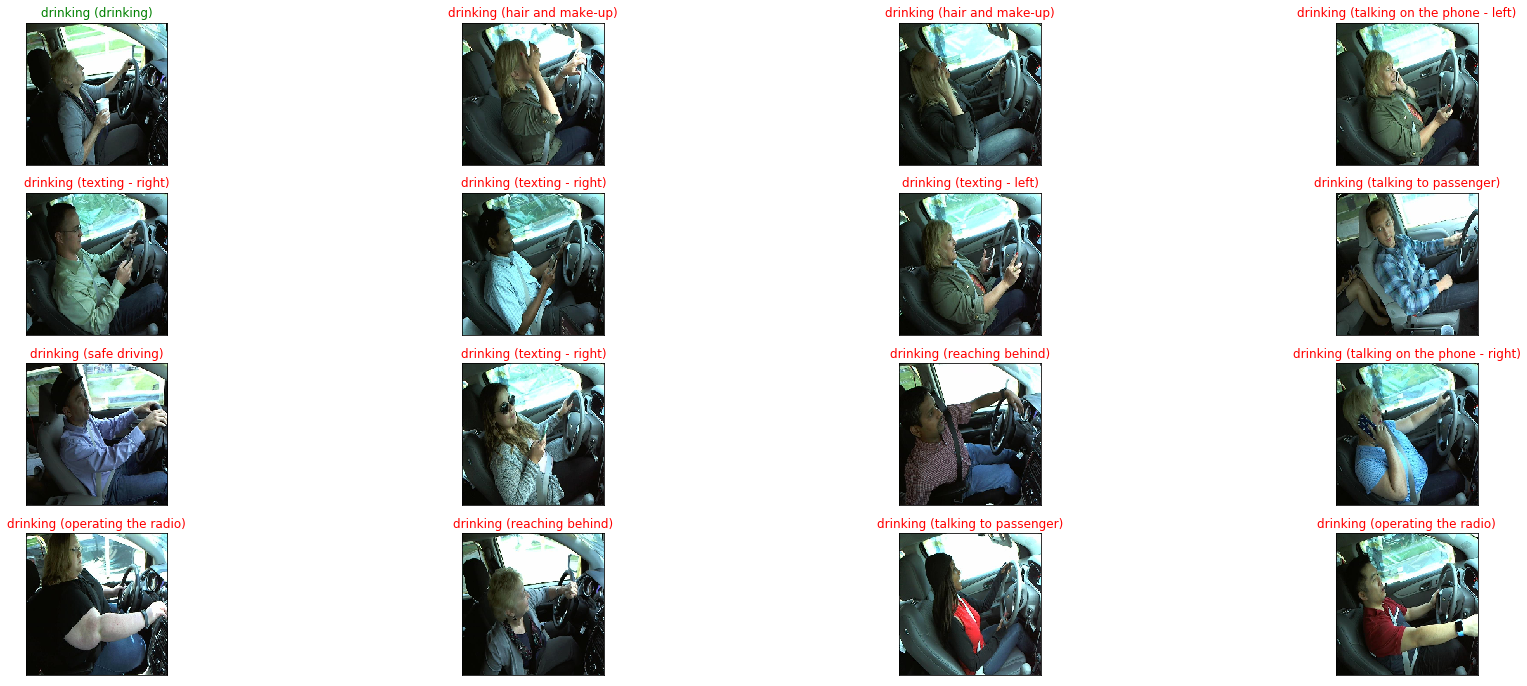

In [19]:
# plot a random sample of test images, their predicted labels, and ground truth
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(30, 12))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(safe_driving_labels[pred_idx], safe_driving_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [20]:
# get predictions on the unlabelled set
y_unlabelled = new_model.predict(X_unlabelled)

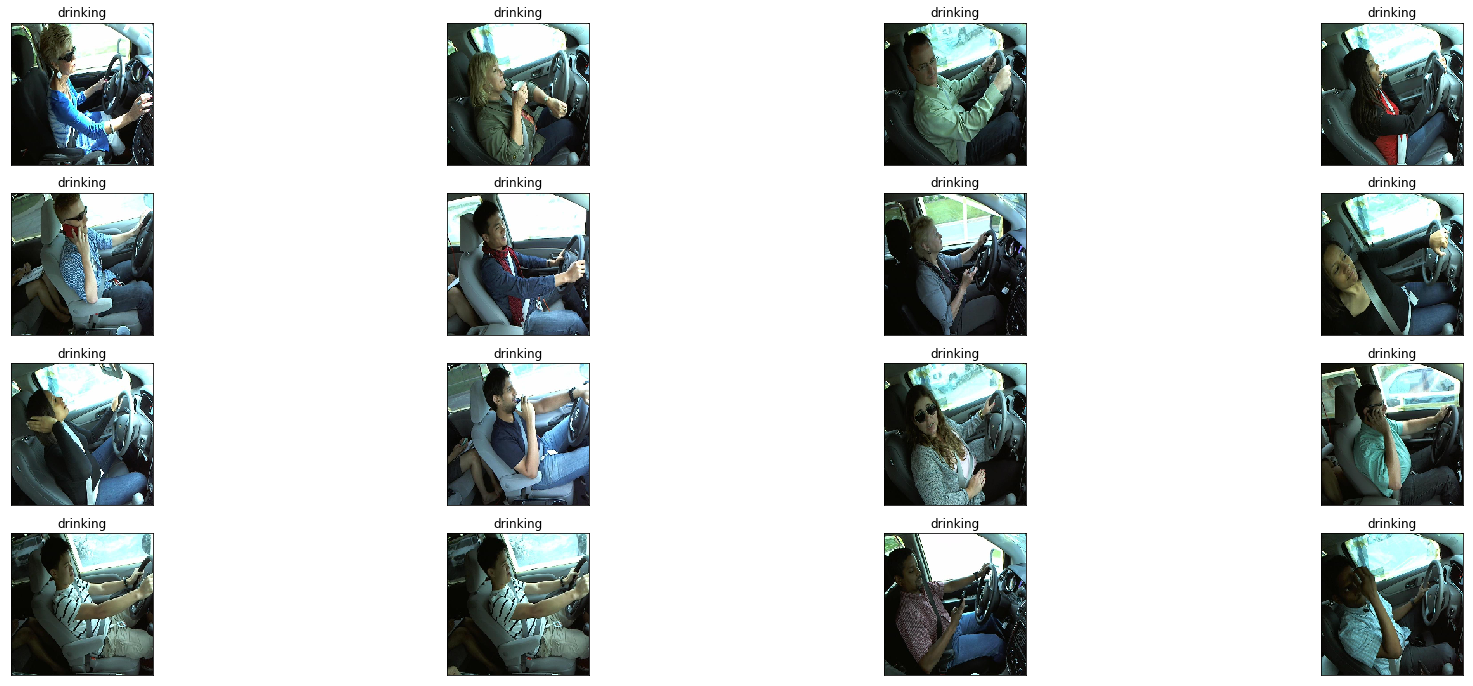

In [22]:
# plot unlabelled prediction to see
fig = plt.figure(figsize=(30, 12))
for i, idx in enumerate(np.random.choice(X_unlabelled.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_unlabelled[idx])
    ax.set_title("{}".format(safe_driving_labels[pred_idx]))